# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/msa?purveyor=owner#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [4]:

brands = ['martin', 'gibson','fender','taylor','ibanez','yamaha','godin','orangewood','prs','gretsch',
          'epiphone']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        continue # skip the listing if it's not the branded guitar we want
    else:
        brand = hits[0]
    data.append({'title':title,'price':price,'link':link,'brand':brand})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [6]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
print(df.shape)
df.to_csv('craigslist_cville_instr.csv') # Save data in case of a disaster
df.head()

(35, 4)


,title,price,link,brand
0,"epiphone ""inspired by"" red 355 guitar",1150,https://charlottesville.craigslist.org/msg/d/s...,epiphone
1,baby taylor koa bte acoustic/electric,500,https://charlottesville.craigslist.org/msg/d/s...,taylor
2,"epiphone ""inspired by"" les paul custom",1050,https://charlottesville.craigslist.org/msg/d/s...,epiphone
3,martin 2005 d35 sunburst acoustic,2800,https://charlottesville.craigslist.org/msg/d/c...,martin
4,gretsch g5410t electromatic “rat rod” hollowbo...,550,https://charlottesville.craigslist.org/msg/d/c...,gretsch


With the data in and wrangled, we can now do EDA:

count      35.000000
mean     1053.828571
std      1358.631091
min         1.000000
25%       187.500000
50%       550.000000
75%      1100.000000
max      5900.000000
Name: price, dtype: float64


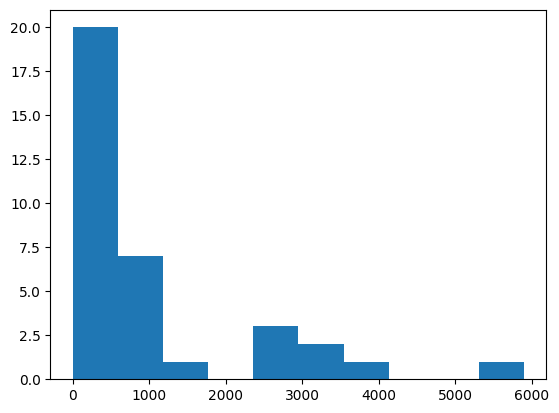

In [8]:
# EDA for price
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()


In [9]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                            \
         count         mean          std     min     25%     50%     75%   
brand                                                                      
epiphone   7.0   792.714286   278.965180   400.0   575.0   899.0   975.0   
fender    13.0   810.076923  1580.425336     1.0   160.0   200.0   650.0   
gibson     1.0  2499.000000          NaN  2499.0  2499.0  2499.0  2499.0   
gretsch    2.0   495.000000    77.781746   440.0   467.5   495.0   522.5   
ibanez     1.0     1.000000          NaN     1.0     1.0     1.0     1.0   
martin     2.0  2650.000000   212.132034  2500.0  2575.0  2650.0  2725.0   
prs        3.0  3499.666667   264.953455  3299.0  3349.5  3400.0  3600.0   
taylor     1.0   500.000000          NaN   500.0   500.0   500.0   500.0   
yamaha     5.0   203.000000   149.315103    15.0   150.0   150.0   300.0   

                  
             max  
brand             
epiphone  1150.0  
fender    5900.0  
gibson    2499.0  
gretsch    550.0  
ibanez       1.0  
martin    2800.0  
prs       3800.0  
taylor     500.0  
yamaha     400.0

<ipython-input-23-426967250047>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df, x='brand', y='price',palette='viridis')


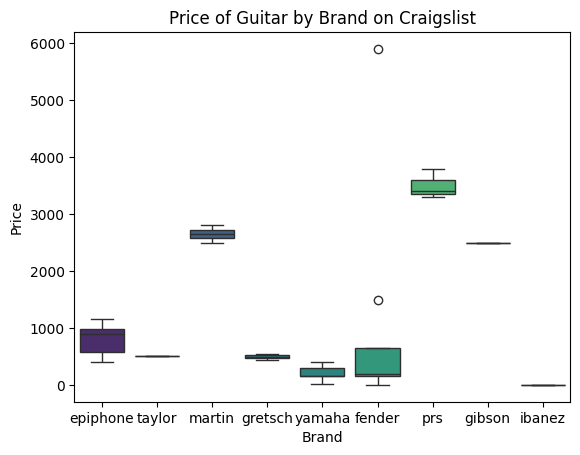

In [23]:
ax = sns.boxplot(data=df, x='brand', y='price',palette='viridis')
plt.title('Price of Guitar by Brand on Craigslist')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.show()